In [1]:
import cv2
from datetime import datetime
import ipywidgets
from IPython.display import display
from matplotlib import pyplot as plt
import os
from pi.motor_control import MotorControl
from picamera2 import Picamera2, Preview
import time

In [2]:
# Start the camera as we have explained in `01_testing_the_camera` notebook
picam2 = Picamera2()
# using the default configuration for now
camera_config = picam2.create_preview_configuration()
picam2.configure(camera_config)
# Start the preview and camera
picam2.start_preview(Preview.NULL)
picam2.start()
time.sleep(2)

[0:39:22.770883984] [1031]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+46-075b54d5
[0:39:22.819505968] [1050]  WARN RPiSdn sdn.cpp:39 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:39:22.821675990] [1050]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx477@1a to Unicam device /dev/media3 and ISP device /dev/media1
[0:39:22.821733452] [1050]  INFO RPI pipeline_base.cpp:1144 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:39:22.824757764] [1031]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+46-075b54d5
[0:39:22.851184370] [1053]  WARN RPiSdn sdn.cpp:39 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:39:22.853393669] [1053]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx477@1a to Unicam device /dev/media3 and ISP device /dev/media1
[0:39:22.853450521] [1053]  INFO RPI pipeline_base.cpp:1144 Using configuration file '/usr/share/libcamera/pipeline/r

In [3]:
# Connect to the motor, see the previous notebook for more details
motor_control = MotorControl()

In [4]:
def ensure_directory_exists(relative_directory):
    absolute_directory = os.path.abspath(relative_directory)
    if not os.path.isdir(absolute_directory):
        os.makedirs(absolute_directory)
    return absolute_directory

data_dir = ensure_directory_exists("../data/new")

In [5]:
def take_picture():
    return picam2.capture_array("main")
def bytes_to_jpg(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return bytes(cv2.imencode('.jpg', img_rgb)[1])

In [6]:
# I changed this to make sure my new pictures are more in line with the older ones.
# Probably the upgrade from rpicam to picam2 changed the default exposure value.
# If this is the first time taking pictures, there is not much point in setting this or any other control setting.
# For reference, all settings can be found in the appendix of the official picamera documentation: https://datasheets.raspberrypi.com/camera/picamera2-manual.pdf 
picam2.set_controls({"ExposureValue": 1})

In [8]:
def write_image(image_bytes, prefix = ''):
    filename = os.path.join(data_dir, prefix + datetime.now().strftime("%Y%m%d%H%M%S") + ".jpg")
    with open(filename, "wb") as file:
       file.write(image_bytes)
    return filename

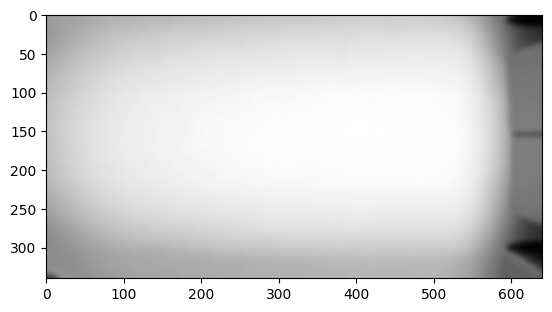

In [11]:
top_border = 100
bottom_border = 40
    
def pre_process_image(image):
    without_borders = image[top_border:480-bottom_border,:]
    gray = cv2.cvtColor(without_borders, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    return gray

# We take an initial picture with no bricks on the belt. This will be our reference image so we can detect when a brick is on the belt.
# Make sure there are no bricks on the camera belt when you run this cell.
first_picture = take_picture()
write_image(bytes_to_jpg(first_picture), 'reference')
first_image = pre_process_image(first_picture)
plt.imshow(first_image, cmap='gray')

In [12]:
# This function takes a picture and compares is against the reference image.
# If a change is detected (a brick is on the belt), it will return the x coordinate of the leftmost contour.

def update_image(image_widget: ipywidgets.Image = None, processed_widget: ipywidgets.Image = None):
    cam_img = take_picture()
    if image_widget:
        image_widget.value = bytes_to_jpg(cam_img)
    gray = pre_process_image(cam_img)
    
    image_diff = cv2.absdiff(first_image, gray)
    thresh = cv2.threshold(image_diff, 50, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    left_most_contour_x = 640
    for c in contours:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 40:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 600 or w < 50:
            continue
        cv2.rectangle(cam_img, (x, y + top_border), (x + w, y + h + top_border), (0, 255, 0), 2)
        if x < left_most_contour_x:
            left_most_contour_x = x 

    image_widget.value = bytes_to_jpg(cam_img)
    if processed_widget:
        processed_widget.value = bytes_to_jpg(thresh)
    return left_most_contour_x

In [13]:
# These widgets will show what is happening in the machine. The left one will show the camera feed, and the right one will show the processed image that
# is used to detect the bricks.
# To test, manually put a brick on the belt. If you took the reference image correctly, you should see a rectangle around the brick.
image_widget = ipywidgets.Image(format='jpeg')
processed_widget = ipywidgets.Image(format='jpeg')

display(ipywidgets.HBox([image_widget, processed_widget]))

update_image(image_widget, processed_widget)

640

In [14]:
# This is where we start the machine. For a first run, put one or two bricks on the main belt and run this cell.
# The machine will detect the brick, move it to the center, take a picture, and continue.
# For now, everything will just go to one bucket. When you are confident this is working, you can load up the feeder and let it run.
# To stop the machine, run the cell below.
# Ideally, you pick two or 3 different block types and let the machine run for a while. Make at least 50 pictures, the more the better.
# When you have taken the pictures, go back to the main README to learn how to process the images and train the model.
import threading
from time import sleep
running = True
def update_image_loop():
    global running
    motor_control.on_all()
    while running:
        contour_x = update_image(image_widget, processed_widget)
        if  contour_x < 640:
            motor_control.stop_all()
            sleep(0.5) # wait for brick to drop
            contour_x = update_image(image_widget, processed_widget)
            motor_control.move_to_center(contour_x)
            sleep(0.5)
            write_image(bytes_to_jpg(take_picture()))
            sleep(0.5)
            motor_control.clear_camera_belt()
            sleep(2)
            motor_control.on_all()
    motor_control.stop_all()
        
t = threading.Thread(target=update_image_loop)
t.start()

# Tuning the machine

Initially, it is best to start with only a limited selection of bricks. I took 3 different brick types, but for one, I did use multiple colors.

First load the feeder with only a few bricks and closely inspect what happens. 

- Bricks should gradually move through the feeder and the big belt. You can change the angle of the flaps on the main belt. In general, you want bigger angles initially and smaller later on.
- Bricks should not get stuck. However, because of the nature of the bricks and the LEGO belts, things could go wrong. Personally, I never run the machine unattended and after a few minutes, you'll notice by the sound when things go wrong.
- You could also adapt the `update_image` code. There are many ways to skin a cat, and there are even more ways to detect changes between pictures.

No matter how much tweaking you do, you will find some incorrectly photographed bricks. Typically, these are:

- empty pictures with no brick
- two or more bricks

We will clean this up later, so for now, don't worry too much about it and focus on getting as many pictures as possible. It may get a bit boring, but for good measure, take some more pictures! 

When you are done, stop the machine and release all resources. 

In [15]:
# Stop the machine. This will stop the loop, but not release all resources, so you can restart the by simply running the cell above again.
running = False
t.join()

In [16]:
# Release all resources. This will fully stop everything. You will need to rerun most cells in this notebook to restart the machine.
picam2.stop()
picam2.stop_preview()
picam2.close()
motor_control.close()

# Summary

In this notebook, we have built a simple machine that can take pictures of LEGO bricks. We have used the camera to detect when a brick is on the belt and move it to the center. We have taken pictures of the bricks and saved them to disk.

Run the machine for some time, more than you would think is okay. The more pictures you have, the better the model will be.

When you have at least 20 to 30 pictures of each brick tip, return to the main readme of the project for the next step: "Training the model".